<a href="https://colab.research.google.com/github/meadpusher/UEC-ANP-Simulator/blob/main/UEC_ANP_Assessment_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UEC ANP Assessment Simulation

**Dean O'Callaghan - January 2024**

Healthcare provision is complicated. The effect of any given change, large or small, can be very difficult to predict. Yet all too often we are in the situation where we try to measure the impact of a change after it has already happened.

Computer simulation cannot prevent this entirely, but after real life testing, there is no better tool for predicting the outcomes of a change than a full simulation. By building computer models we are able to run these simulations thousands to millions of times, greatly increasing our confidence in the likely outcome when we come to testing and giving us much better chances of mitigating against any negative or unintended effects.

This notebook provides an example of how a fairly simple simulation can be used to model an environment and provide some information on how to implement it. It does not explain in any detail how the python code it is written in works as that is besides the point - simulations can be built using basic excel functions - instead it walks through a method of creating a simulation, testing it, and using it, in a practical scenario.

The purpose here is to demonstrate the power of simulations. Not to advocate for any particular urgent care or initial assessment model.

>**Note:** An interactive version of the simulation is provided at the very end. *Make sure you run all the set-up cells to use it!*

> ### The Problem
> An A&E department is considering changing its arrival system, from a short streaming system, to using a longer form of assessment for more accurate early streaming.
> The A&E Department wants to use a simulation to get a rough estimate for the staffing level required if making this change to meet its *Initial Assessment* target, which for the principles of this exercise means 90% of patients should be seen within 15 minutes.

> ### Assumptions
> * Assessments are done by Advanced Nurse Practitioners (ANPs)
> * Demand is given in terms of patients arriving per hour and is set up at five different levels from `LOW` to `VERY_HIGH`, ranging from 5 to 25 per hour.
> * Each assessment will have:
>   1. a minimum length (assumption is that in this form even the quickest patients will take a certain amount of time)
>   2. a maximum length (after which they need to move to next patient)
>   3. an expected length
> * By default these are set to 5 minutes, 30 minutes, and 20 minutes respectively.

#### Additional Information

The model also includes a breach limit, by default set to 15 minutes. Any patients waiting longer than this are considered to be a breach of the initial assessment target.

The model will simulate one hour of arrivals (with a 30 minute prelude to fill the waiting area and ANP rooms)

At the end of the hour it will report on the average time a patient was waiting to be seen, the average time a patient spent waiting to be seen plus the consultation time (time in system), the average number of patients waiting to be seen, the number of breaches, and the number of patients not seen

The simulation by default will run 150 times

An average of the statistics will be reported

The simulation can be run for a given number of ANPs and used to work out how many ANPs should be on shift for a given level of demand.

## Imports

Run this code to initialise the notebook and bring in the python libraries we need to run the simulation. We also set up some fixed enumerations that will make it easier to control the program. The `DISABLE_MULTIPROCESSING` constant can be set to True if your notebook does not support the multiprocessing library

In [1]:
import random
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from multiprocessing import Pool
import multiprocessing
import math
from enum import Enum

# Multiprocessing constants
NUM_CPUS = multiprocessing.cpu_count()
DISABLE_MULTIPROCESSING = False

class DemandLevel(Enum):
  VERY_LOW = 5   # 5 patients per hour (120 per day)
  LOW = 10       # 10 patients per hour (240 per day)
  MEDIUM = 15    # 15 patients per hour (360 per day)
  HIGH = 20      # 20 patients per hour (480 per day)
  VERY_HIGH = 25 # 25 patients per hour (600 per day)

class Volatility(Enum):
  HIGH = 1        # More spreadout consultation times (will tend to go over limits)
  MEDIUM = 0.5    # Medium level of spread from expected consultation time
  LOW = 0.3       # Less spreadout consultation times (closer to expected time)

class DistributionModel(Enum):
  NORMAL = 0      # Use a normal distribution
  LOGNORMAL = 1   # Use a log-normal distribution (waiting towards longer consult times)

Default values for the simulation are set below

In [2]:
DEFAULT_MODEL_DURATION = 60         # How many minutes to model
DEFAULT_NUM_ANPS = 1                # How many ANPs working during simulation
DEFAULT_DEMAND_LEVEL = 'MEDIUM'     # The demand level to run the simulation at
DEFAULT_VOLATILITY = 'MEDIUM'       # How volatile to spread consult times
DEFAULT_MODELLING = 'NORMAL'        # How to model the consultation times: 'NORMAL' | 'LOGNORMAL'
DEFAULT_CONTROL_LIMIT = 15          # The waiting time breach limit
DEFAULT_MIN_CONSULT_TIME = 5        # The minimum possible consultation length
DEFAULT_MAX_CONSULT_TIME = 30       # The longest possible consultation length
DEFAULT_EXPECTED_CONSULT_TIME = 20  # The expected consultation length
DEFAULT_SIM_RUNS = 150              # Number of times to run the simulation
DEFAULT_MIN_SEEN_BREAK = 4          # Minimum number of patients an ANP will see before maybe wanting a mini-break
DEFAULT_MAX_SEEN_BREAK = 8          # The most patients an ANP can see before needing a break

## Model Definitions

This next section contains the definitions our simulation will use for patients and ANPs. We also set up how we want the waiting area to behave. The final class is the simulation class, which is what we will use to run the simulation.

Run each cell to initialise each class definition

The first class we set up is the Patient class. This defines how patients will behave. The class is fairly simple but note that patients are tracking their own vital statistics. If we want to expand the model later or add in logging then this type of implementation should make it a bit easier to do

In [3]:
class Patient:
  def __init__(self, arrival_time, model_duration, volatility_level=Volatility[DEFAULT_VOLATILITY].value,
               dist=DistributionModel[DEFAULT_MODELLING].value):
    """
    Initialise a new patient.
    :param arrival_time: The time the patient arrives at the urgent care (in minutes starting at 0)
    :param volatility_level: How volatile the consultation time method will be (Volatility value)
    :param dist: Which distribution to use for the consultation time method (DistributionModel value)
    """
    # Do not log if arrival time is negative. Allows for intentional waiting room build up
    if arrival_time < 0:
      self.arrival_time = 0
      self.do_not_log = True
    else:
      self.arrival_time = arrival_time
      self.do_not_log = False
    self.model_duration = model_duration
    self.start_time = None  # Time when the patient starts being seen by an ANP
    self.consultation_time = None  # Duration of the consultation
    self.has_breached = False
    self.final_wait_time = 0
    self.dist_model = dist
    self.volatility = volatility_level

  def set_consultation_time(self, min_time, expected_time, max_time):
    """
    Set the consultation time for the patient, based on a normal distribution.
    :param min_time: Minimum possible consultation time.
    :param expected_time: Expected consultation time.
    :param max_time: Maximum possible consultation time.
    """
    # Generate a consultation time, ensuring it's within the min and max limits
    if self.dist_model == 0:    # NORMAL DISTRIBUTION
      # Normal distribution with 1 standard deviation range
      standard_deviation = (max_time - min_time) / 2 * self.volatility
      self.consultation_time = random.normalvariate(expected_time, standard_deviation)
    elif self.dist_model == 1: # LOG-NORMAL DISTRIBUTION
      # Log-normal distribution for more values above the mean
      mu, sigma = np.log(expected_time), (max_time - min_time) / 6 * self.volatility
      self.consultation_time = np.random.lognormal(mu, sigma)
    else:
      raise ValueError("Invalid distribution type. Use DistributionModel Enum")
    # Rounding the consultation time to two decimal places or 0.6 seconds
    self.consultation_time = round(max(min_time, min(max_time, self.consultation_time)), 2)

  def set_start_time(self, start_time):
    """
    Set the time when the patient starts being seen by an ANP.
    :param start_time: The start time of the consultation.
    """
    self.start_time = start_time

  def wait_time(self):
    """
    Calculate the wait time of the patient.
    :return: The wait time.
    """
    if self.do_not_log:
      return None
    if self.start_time is not None:
      self.final_wait_time = self.start_time - self.arrival_time
    else:
      self.final_wait_time = self.model_duration - self.arrival_time
    return self.final_wait_time

  def total_time_in_system(self):
    """
    Calculate the total time the patient spends in the system.
    :return: The total time in the system.
    """
    if self.do_not_log:
      return None
    if self.start_time is not None and self.consultation_time is not None:
      return self.consultation_time + self.final_wait_time
    return self.final_wait_time

The next class we implement is the ANP class. The ANP handle calling in patients and so we add a bit of logic here to randomise how long it takes patients to walk to a room, how long the ANP waits before calling the next patient (simulate cleaning the room or minor admin) and even whether the ANP wants a short mini-break.

Adding this type of complication is one of the great things about simulations. It makes predicting the results really difficult as you don't know how these small little delays will add up and effect things. But the simulation will just tell you by running it.

These delays use a beta distribution. A visualisation of this is available at the very end of the notebook to help understand what this is doing if you are interested

In [4]:
class ANP:
  def __init__(self, min_seen_break=DEFAULT_MIN_SEEN_BREAK, max_seen_break=DEFAULT_MAX_SEEN_BREAK):
    """
    Initialise a new ANP (Advanced Nurse Practitioner).
    :param min_seen_break: The minimum number of patients an ANP sees before the ANP may want a break
    :param max_seen_break: The maximum number of patients an ANP can see before the ANP will want a break
    """
    # Constants
    self.MIN_PATIENT_WALK_TIME = 0.25 # Patient takes at least 15 seconds to get to room
    self.MAX_PATIENT_WALK_TIME = 1.0  # Patient takes no longer than 60 seconds to get to room
    self.MIN_ADMIN_TIME = 0.33        # ANP needs at least 20 seconds between patients
    self.MAX_ADMIN_TIME = 2.0         # ANP may wait up to 2 minutes between patients
    self.MIN_MINI_BREAK_TIME = 1.0    # When on mini-break this lasts at least 1 minute
    self.MAX_MINI_BREAK_TIME = 4.0    # When on mini-break this lasts no more than 4 minutes
    self.BREAK_PROBABILITY = 0.2      # The probability of an ANP wanting a break once we are in range

    self.min_seen_break = min_seen_break
    self.max_seen_break = max_seen_break
    self.idle_as_break_time = self.MIN_MINI_BREAK_TIME * 1.2 # If an ANP is idle this amount of time then count as mini-break
    self.is_free = True
    self.current_patient = None
    self.next_free_time = 0
    self.mini_break_count = random.randint(min_seen_break, min_seen_break + 3)
    self.total_mini_break_time = 0

  def reset(self):
    """
    Reset the ANP for the start of a new run.
    """
    self.is_free = True
    self.current_patient = None
    self.next_free_time = 0
    self.mini_break_count = random.randint(self.min_seen_break, self.min_seen_break + 3)
    self.total_mini_break_time = 0

  def reset_mini_break_count(self):
    """
    Helper method used by start_consultation to reset self.mini_break_count.
    This method will have a self.BREAK_PROBABILITY chance of triggering for each
    additional patient called in once we reach self.min_seen_break
    """
    for i in range(self.min_seen_break, self.max_seen_break):
      if random.random() < self.BREAK_PROBABILITY:
        self.mini_break_count = i
      self.mini_break_count = self.max_seen_break

  def generate_delay(self, alpha, beta, min_time, max_time, extra_chance=0, extra_max=0):
    """
    Helper method used by _start_consultation that generates a random delay using a
    beta distribution and an optional extra delay.
    :param alpha: Alpha value for the beta distribution.
    :param beta: Beta value for the beta distribution.
    :param min_time: Minimum time for the delay.
    :param max_time: Maximum time for the delay.
    :param extra_chance: Chance of an extra delay occurring.
    :param extra_max: Maximum extra delay time.
    :return: The generated delay.
    """
    # Generate delay using beta distribution
    beta_value = random.betavariate(alpha, beta)
    delay = min_time + (max_time - min_time) * beta_value

    # Optionally add extra delay
    if random.random() < extra_chance:
      delay += random.uniform(0, extra_max)

    return delay

  # Currently any delay the patient makes in getting to the room is counted as a wait
  # This mimics the behaviour of an ANP not starting a consultation until the patient is
  # sitting down, and hence maxmimises consultation time.
  #
  # Conversely the ANP could start the consultation the moment a patient is called
  # In this scenario the time to get into the consulation will reduce the consultation or
  # cause it to potentially over-run. Whilst this has not been implemented in this model
  # it should be easy enough to do, but it will require adding to the Patient class
  def start_consultation(self, patient, current_time):
    """
    Start a consultation with a patient.
    :param patient: The patient to consult.
    :param current_time: The current time in the simulation.
    """
    # Check how long ANP was idle for
    current_idle_time = self.next_free_time - current_time
    if current_idle_time >= self.idle_as_break_time:
      # Count this idle period as a mini-break
      self.reset_mini_break_count()

    # Generate delay to simulate patient walking into the room
    walk_delay = self.generate_delay(
      alpha=2.0, beta=2.5, # This adds a bit of positive skew, so patients tend to be faster
      min_time=self.MIN_PATIENT_WALK_TIME, max_time=self.MAX_PATIENT_WALK_TIME,
      extra_chance=0.01, extra_max=2.0 # This adds a 1% chance of an up to 2 min delay (e.g. patient comes out of toilet)
    )

    # Update the current time and call in the patient with the patient movement now factored in
    adjusted_start_time = round(current_time + walk_delay, 2)
    self.current_patient = patient
    self.is_free = False
    patient.set_start_time(adjusted_start_time)

    # Handle mini-break logic
    mini_break = 0
    if self.mini_break_count == 1:
      self.reset_mini_break_count()
      mini_break = random.uniform(self.MIN_MINI_BREAK_TIME, self.MAX_MINI_BREAK_TIME) # A mini-break can be any length between min and max values
      self.total_mini_break_time += mini_break
    else:
      self.mini_break_count -= 1

    # Generate admin time delay
    admin_delay = self.generate_delay(
      alpha=3.0, beta=4.0, # This adds quite heavy positive skew, ANP will tend to be faster
      min_time=self.MIN_ADMIN_TIME, max_time=self.MAX_ADMIN_TIME
    )

    # Calculate the next free time
    self.next_free_time = round(adjusted_start_time + patient.consultation_time + mini_break + admin_delay, 2)

  def update_status(self, current_time):
    """
    Update the ANP's status based on the current time.
    :param current_time: The current time in the simulation.
    """
    if current_time >= self.next_free_time:
      self.is_free = True
      self.current_patient = None

  def idle_time(self):
    """
    :return: 1 if idle, 0 if busy
    """
    if self.is_free:
        return 1
    return 0

The next class we set up is the WaitingArea. This is very simple and just tracks who is waiting and who has been seen. Perhaps this could be made more complicated if you wanted to model and track things like blood tests and quick investigations (i.e. have the same patient go and return).

This type of thing could also be done by generating multiple waiting rooms and just leaving tracking the different statistics to the individual Patient. Anyway here we keep things simple.

In [5]:
class WaitingArea:
  def __init__(self):
    """
    Initialise the waiting area.
    """
    self.waitingPatients = []
    self.seenPatients = []

  def reset(self):
    """
    Reset the waiting area for a new run.
    """
    self.clear_waiting_area()

  def add_patient(self, patient):
    """
    Add a new patient to the waiting area.
    :param patient: The patient to add.
    """
    self.waitingPatients.append(patient)

  def has_waiting_patients(self):
    """
    Check if there are any patients waiting.
    :return: True if there are patients waiting, False otherwise.
    """
    return (len(self.waitingPatients) > 0)

  def next_patient(self):
    """
    Get the next patient in line.
    :return: The next patient if available, None otherwise.
    """
    if self.has_waiting_patients():
      patient = self.waitingPatients[0]
      self.seenPatients.append(patient)
      self.waitingPatients.pop(0)
      return patient
    return None

  def clear_waiting_area(self):
    """
    Clear all patients from the waiting area.
    """
    self.waitingPatients.clear()
    self.seenPatients.clear()

  def waiting_count(self):
    """
    Get the number of patients currently waiting.
    :return: Number of patients waiting.
    """
    return len(self.waitingPatients)

Finally we implement the Simulation class. This is like our games master.

In [6]:
class Simulation:
  def __init__(self, demand_level=DEFAULT_DEMAND_LEVEL, num_ANPs=DEFAULT_NUM_ANPS, duration=DEFAULT_MODEL_DURATION,
               wait_control=DEFAULT_CONTROL_LIMIT, max_time=DEFAULT_MAX_CONSULT_TIME,
               expected_time=DEFAULT_EXPECTED_CONSULT_TIME, min_time=DEFAULT_MIN_CONSULT_TIME,
               num_simulations=DEFAULT_SIM_RUNS, model_volatility=DEFAULT_VOLATILITY,
               consult_dist=DEFAULT_MODELLING, min_break_no=DEFAULT_MIN_SEEN_BREAK,
               max_break_no=DEFAULT_MAX_SEEN_BREAK, pre_run_time=30):

    """
    Initialise the simulation with given parameters.
    :param demand_level: The demand level (must be positive)
    :param num_ANPs: The number of ANPs (must be integer >= 1)
    :param duration: The model duration (must be positive integer)
    :param wait_control: The initial assessment breach limit (cannot be negative)
    :param max_time: The maximum time a patient can spend in an ANP assessment
    :param min_time: The minimum time a patient can spend in an ANP assessment
    :param num_simulations: The number of times to run the simulation (positive integer)
    :param model_volatility: The Volatility level to use for consultation times
    :param consult_dist: The DistributionModel to use for consultation times
    :param min_break_no: The minimum number of patients an ANP will see before maybe wanting a break (positive int)
    :param max_break_no: The maximum number of patients an ANP can see before taking a break (positive int)
    :param pre_run_time: The amount of time to run the simulation before measuring statistics (positive integer)
    """
    # Simple Error Handling
    if(min_break_no > max_break_no):
      min_break_no, max_break_no = max_break_no, min_break_no
    if(min_time > max_time):
      min_time, max_time = max_time, min_time
    if(expected_time < min_time):
      expected_time = min_time
    if(expected_time > max_time):
      expected_time = max_time
    pre_run_time = int(pre_run_time)
    pre_run_time = 1 if pre_run_time < 0 else pre_run_time
    duration = int(duration)
    duration = 1 if duration < 0 else duration
    num_simulations = int(num_simulations)
    num_simulations = 1 if num_simulations < 0 else num_simulations
    wait_control = 1000000 if wait_control < 0 else wait_control  # Set wait_control to a million if negative

    # Check how demand_level was passed
    if isinstance(demand_level, DemandLevel):
      demand_level = demand_level.value
    if isinstance(demand_level, str):
      try:
        demand_level = DemandLevel[demand_level].value
      except:
        demand_level = DemandLevel[DEFAULT_DEMAND_LEVEL].value
    # Check how model_volatility was passed
    if isinstance(model_volatility, Volatility):
      model_volatility = model_volatility.value
    if isinstance(model_volatility, str):
      try:
        model_volatility = Volatility[model_volatility].value
      except:
        model_volatility = Volatility[DEFAULT_VOLATILITY].value
    # Check how consult_dist was passed
    if isinstance(consult_dist, DistributionModel):
      consult_dist = consult_dist.value
    if isinstance(consult_dist, str):
      try:
        consult_dist = DistributionModel[consult_dist].value
      except:
        consult_dist = DistributionModel[DEFAULT_MODELLING].value

    # Main simulation parameters
    self.demand_level = 0 if demand_level < 0 else demand_level # Number of patients expected per hour
    self.pre_run_mins = int(pre_run_time)                       # The number of minutes to run simulation before running statistics
    self.model_duration = duration + self.pre_run_mins          # Model duration (add 30 minutes lead time)
    self.min_break_no = int(min_break_no)                       # Minimum patients before possible break for ANP
    self.max_break_no = int(max_break_no)                       # Maximum patients before break for ANP
    self.num_ANPs = int(num_ANPs) if num_ANPs > 0 else 1        # Number of working ANPs
    self.wait_control = wait_control                            # Waiting time target (default is 15 minutes)
    self.max_time = max_time                                    # Max time an ANP can spend with a patient (default is 30 minutes)
    self.expected_time = expected_time                          # Expected time with a patient (default is 15 minutes)
    self.min_time = min_time                                    # Minimum time with a patient (default is 5 minutes)
    self.num_simulations = num_simulations                      # Number of times to run simulation (default is 150)
    self.volatility = model_volatility                          # Model volatility factor
    self.model_dist = consult_dist                              # Type of distribution to use using DistributionModel Enum
    self.no_multi_processing = DISABLE_MULTIPROCESSING or NUM_CPUS < 3
    self.notRun = True
    # Statistics
    self.avg_wait_time = 0
    self.avg_breaches = 0
    self.avg_patients_waiting = 0
    self.avg_idle_time = 0
    self.avg_system_time = 0
    self.avg_consultation_time = 0
    self.avg_not_seen = 0
    self.avg_arrivals = 0
    # Objects
    self.ANPs = [ANP(self.min_break_no, self.max_break_no) for _ in range(self.num_ANPs)]
    self.waiting_area = WaitingArea()

  def __repr__(self):
    """
    Print main statistics, but only after simulation has been run
    """
    if self.notRun:
      return "Simulation not run"
    return (f"Simulation Results for {self.demand_level} Patients per Hour with {self.num_ANPs} ANPs:\n"
    f"  - Average Wait Time: {self.avg_wait_time:.2f} mins\n"
    f"  - Average Breach Rate: {100 * (self.avg_breaches / self.avg_arrivals):.1f}%\n"
    f"  - Average Patients Waiting: {self.avg_patients_waiting:.2f}\n"
    f"  - Average ANP Idle Time: {self.avg_idle_time:.2f} mins per hour\n"
    f"  - Average Time in System: {self.avg_system_time:.2f} mins\n"
    f"  - Average Consultation Time: {self.avg_consultation_time:.2f} mins\n"
    f"  - Average Patients Not Seen: {self.avg_not_seen:.2f}\n"
    f"  - Average No. Arrivals: {self.avg_arrivals:.2f}\n"
    f"  - Number of runs: {self.num_simulations:,}\n"
    f"  - Sim Run Duration: {self.model_duration - self.pre_run_mins} minutes\n"
    f"  - Full Run Duration: {self.model_duration} minutes\n"
    "--------------------------------------------------\n")

  def run_simulation(self):
    """
    Run a single simulation and return statistics.
    :return: [avg_wait_time, tot_breaches, avg_patients_waiting, avg_idle_time, avg_system_time, avg_consultation_time, not_seen, total_arrivals]
    """
    # Initialise variables for statistics
    wait_times = []
    system_times = []
    breach_counts = []
    idle_times = []
    waiting_counts = []
    consultation_times = []
    total_arrivals = 0
    not_seen = 0

    # Generate patient arrivals
    patient_arrivals = None
    patient_arrivals = self.generate_patient_arrivals()

    # Simulate 90? minutes (including 30 minutes lead time)
    ticker = 0.0
    while ticker < self.model_duration:
      # Add arriving patients to the waiting area
      while patient_arrivals and patient_arrivals[0] <= ticker:
        p_arrival_time = ticker # ticker if ticker >= self.pre_run_mins else -1 # Use this to exclude pre_run patients from statistics
        new_patient = Patient(p_arrival_time, self.model_duration, self.volatility, self.model_dist)
        new_patient.set_consultation_time(self.min_time, self.expected_time, self.max_time)
        self.waiting_area.add_patient(new_patient)
        patient_arrivals.pop(0)

      # Update ANPs and assign patients
      for anp in self.ANPs:
        anp.update_status(ticker)
        if anp.is_free and self.waiting_area.has_waiting_patients():
          anp.start_consultation(self.waiting_area.next_patient(), ticker)

      if ticker >= self.pre_run_mins:  # Start collecting statistics after the initial 30 minutes
        # Collect statistics for this minute
        idle_times.append(sum(anp.idle_time() for anp in self.ANPs))
        waiting_counts.append(self.waiting_area.waiting_count())
        for patient in self.waiting_area.waitingPatients:
          if not patient.has_breached and ((ticker - patient.arrival_time) > self.wait_control):
            breach_counts.append(1)
            patient.has_breached = True

      # Move the ticker on by 0.1 minutes (6 seconds)
      ticker += 0.1

    # Calculate average wait times by looping through all patients
    for patient in self.waiting_area.waitingPatients:
      if patient.arrival_time >= self.pre_run_mins:
        wait_times.append(patient.wait_time())
        system_times.append(patient.total_time_in_system())
        if patient.arrival_time <= (self.model_duration - self.wait_control):
          not_seen +=1
          total_arrivals += 1
    for patient in self.waiting_area.seenPatients:
      if patient.start_time >= self.pre_run_mins:
        wait_times.append(patient.wait_time())
        system_times.append(patient.total_time_in_system())
        consultation_times.append(patient.consultation_time)
        if patient.arrival_time >=self.pre_run_mins:
          total_arrivals +=1

    # Remove Nones
    wait_times = [time for time in wait_times if time != None]
    system_times = [time for time in system_times if time != None]

    # Append ANP break times
    for anp in self.ANPs:
      idle_times.append(anp.total_mini_break_time)

    # Calculate averages for the collected statistics
    avg_wait_time = sum(wait_times) / len(wait_times) if len(wait_times) > 0 else 0
    avg_system_time = sum(system_times) / len(system_times) if len(system_times) > 0 else 0
    avg_consultation_time = sum(consultation_times) / len(consultation_times) if len(consultation_times) > 0 else 0
    tot_breaches = sum(breach_counts) if len(breach_counts) > 0 else 0
    avg_idle_time = sum(idle_times) / self.num_ANPs if len(idle_times) > 0 else 0
    avg_idle_time = 60 * avg_idle_time / self.model_duration
    avg_patients_waiting = sum(waiting_counts) / len(waiting_counts) if len(waiting_counts) > 0 else 0

    # Reset waiting room and ANPs
    self.waiting_area.reset()
    for anp in self.ANPs:
        anp.reset()

    return avg_wait_time, tot_breaches, avg_patients_waiting, avg_idle_time, \
    avg_system_time, avg_consultation_time, not_seen, total_arrivals

  def generate_patient_arrivals(self):
    """
    Generate random patient arrival times based on demand level.
    :return: A list of arrival times based on self.model_duration
    """
    arrivals = []
    for _ in range(int(self.demand_level * (self.model_duration/60))):
      # Randomly distribute patient arrivals over 90 minutes
      arrival_time = round(random.uniform(0, self.model_duration - 1), 2)
      arrivals.append(arrival_time)
    arrivals.sort()
    return arrivals

  def run_simulation_wrapper(self, _):
    """
    Wrapper for the run_simulation method to be used with multiprocessing.
    """
    return self.run_simulation()

  def simulate(self):
    """
    Run the simulation multiple times return averaged statistics.
    :return: avg_stats: [wait_time, breaches, patients_waiting, idle_time, system_time, consult_time, not_seen, arrivals]
    """
    # Accumulate statistics over multiple runs
    accumulated_stats = [0, 0, 0, 0, 0, 0, 0, 0]

    if self.no_multi_processing:
      # Run without multiprocessing
      for _ in range(self.num_simulations):
        stats = self.run_simulation()
        for i in range(len(accumulated_stats)):
          accumulated_stats[i] += stats[i]
    else:
      # Run with multiprocessing
      with Pool(NUM_CPUS) as pool:
        results = pool.map(self.run_simulation_wrapper, range(self.num_simulations))
      for stats in results:
        for i in range(len(accumulated_stats)):
          accumulated_stats[i] += stats[i]

    # Calculate averages
    avg_stats = [x / float(self.num_simulations) for x in accumulated_stats]
    self.notRun = False
    self.avg_wait_time, self.avg_breaches, self.avg_patients_waiting, self.avg_idle_time, \
    self.avg_system_time, self.avg_consultation_time, self.avg_not_seen, self.avg_arrivals = avg_stats
    return avg_stats

The cell below implements a helper function to quickly create and report on simulation runs

In [7]:
# Function to run a simulation and print the results
def run_and_print_simulation(demand_level, num_ANPs, duration=DEFAULT_MODEL_DURATION, wait_control=DEFAULT_CONTROL_LIMIT,
                             max_time=DEFAULT_MAX_CONSULT_TIME, expected_time=DEFAULT_EXPECTED_CONSULT_TIME,
                             min_time=DEFAULT_MIN_CONSULT_TIME,  num_simulations=DEFAULT_SIM_RUNS,
                             model_volatility=DEFAULT_VOLATILITY, consult_dist=DEFAULT_MODELLING):
  sim = Simulation(demand_level, num_ANPs, duration, wait_control, max_time,
                   expected_time, min_time, num_simulations, model_volatility, consult_dist)
  sim.simulate()
  print(sim)

## Testing Simulation

We can test the simulation by doing fewer runs and checking that the results in the output statistics make sense.

Here we run the simulation at an estimated required load and then try it at levels just above and below this. At this level we expect to see the patient wait times and numbers waiting, as well as the ANP idle time moving in expected directions. If this isn't the case we can re-look at what may be causing the unexpected results.

In [8]:
# Set a demand level
demand = DemandLevel.MEDIUM

# For a given demand let's try estimating the number of ANPs based on their consultation time
minutes_per_patient = 60 / demand.value
minutes_per_consultation = DEFAULT_EXPECTED_CONSULT_TIME
expected_no_ANPs = math.ceil(minutes_per_consultation / minutes_per_patient)

# Print the results for a few ANPs above, at, and below the expected number
print("Expected ANPs:", expected_no_ANPs)
print("Two Under:")
run_and_print_simulation(demand, expected_no_ANPs - 2, num_simulations = 5)
print("One Under:")
run_and_print_simulation(demand, expected_no_ANPs - 1, num_simulations = 5)
print("Expected:")
run_and_print_simulation(demand, expected_no_ANPs, num_simulations = 5)
print("One Over:")
run_and_print_simulation(demand, expected_no_ANPs + 1, num_simulations= 5 )

Expected ANPs: 5
Two Under:
Simulation Results for 15 Patients per Hour with 3 ANPs:
  - Average Wait Time: 21.84 mins
  - Average Breach Rate: 103.6%
  - Average Patients Waiting: 5.95
  - Average ANP Idle Time: 0.54 mins per hour
  - Average Time in System: 31.78 mins
  - Average Consultation Time: 20.17 mins
  - Average Patients Not Seen: 5.00
  - Average No. Arrivals: 11.00
  - Number of runs: 5
  - Sim Run Duration: 60 minutes
  - Full Run Duration: 90 minutes
--------------------------------------------------

One Under:
Simulation Results for 15 Patients per Hour with 4 ANPs:
  - Average Wait Time: 12.23 mins
  - Average Breach Rate: 50.9%
  - Average Patients Waiting: 3.02
  - Average ANP Idle Time: 49.28 mins per hour
  - Average Time in System: 24.68 mins
  - Average Consultation Time: 20.43 mins
  - Average Patients Not Seen: 1.80
  - Average No. Arrivals: 10.60
  - Number of runs: 5
  - Sim Run Duration: 60 minutes
  - Full Run Duration: 90 minutes
-------------------------

We can also run more in depth tests on parts of the model. The code below will test the Patient class to better understand what kinds of consultation times it is generating. We can test it with different settings to understand how well it is working and what settings best match what we expect to see.

In [9]:
def test_consultation_time_distribution(num_patients=1000, min_time=DEFAULT_MIN_CONSULT_TIME,
                                        expected_time=DEFAULT_EXPECTED_CONSULT_TIME,
                                        max_time=DEFAULT_MAX_CONSULT_TIME, volatilty_setting=None,
                                        model_setting=None):
  """
  Test the distribution of consultation times
  :param num_patients: The number of patients to run the test with
  :param min_time: The minimum consultation time
  :param expected_time: The expected consultation time
  :param max_time: The maximum consultation time
  :param volatility_setting: A selected volatility from Volatility
  :param model_setting: A selected distribution model from DistributionModel
  :return results: Statistics for each volatility and distribution model
  """
  results = []

  for volatility in Volatility:
    if (volatilty_setting is not None) and (volatility != volatilty_setting):
      continue
    for dist_model in DistributionModel:
      if (model_setting is not None) and (dist_model != model_setting):
        continue
      print(f"\rTesting with Volatility: {volatility.name}, Distribution Model: {dist_model.name}", end='', flush=True)
      consultation_times = []

      for _ in range(num_patients):
        patient = Patient(arrival_time=0,model_duration=90,
                          volatility_level=volatility.value,
                          dist=dist_model.value)
        patient.set_consultation_time(min_time, expected_time, max_time)
        consultation_times.append(patient.consultation_time)

      # Calculating statistics
      min_time = min(consultation_times)
      max_time = max(consultation_times)
      mean_time = np.mean(consultation_times)
      lower_quartile = np.percentile(consultation_times, 25)
      median_time = np.median(consultation_times)
      upper_quartile = np.percentile(consultation_times, 75)
      iqr_time = upper_quartile - lower_quartile

      stats = {
        "Min Consult Time": min_time,
        "Max Wait Time": max_time,
        "Mean Wait Time": mean_time,
        "Lower Quartile Wait Time": lower_quartile,
        "Median Wait Time": median_time,
        "Upper Quartile Wait Time": upper_quartile,
        "IQR Wait Time": iqr_time
      }
      results.append((volatility.name, dist_model.name, stats, consultation_times))
  print(f"\rFinished Tests", end='', flush=True)
  print("\n")
  return results

def set_plot_format(plot, title):
  """
  Helper function to convert the y-axis labels to percentages for plots
  :param plot: The plot
  :param title: The plot's title
  """
  # Formatter to convert y-axis labels to percentages
  formatter = mticker.FuncFormatter(lambda x, pos: f"{int(x * 100)}%")
  plot.gca().yaxis.set_major_formatter(formatter)

  plot.title(title)
  plot.xlabel("Consultation Time (minutes)")
  plot.ylabel("Percentage")
  plot.legend()
  plot.show()
  print("\n")

def print_consult_times_test(results, include_plot=False, split_plot=True, hide_stats=False):
  """
  Helper method to print out results and optionally plot from test_consultation_time_distribution
  :param results: Results from test_consultation_time_distribution
  :param include_plot: Boolean to determine whether to include the plot
  :param split_plot: Boolean to determine whether to split the plot for each group
  :param hide_stats: Boolean to hide the statistics at the end
  """
  if include_plot:
    # Use a colormap for distinct colors
    colormap = mpl.colormaps['Set1']   # 'Set1', 'tab10' or 'tab20' may be good
    # Group results by distribution model
    grouped_results = {}
    for volatility, dist_model, _, times in results:
        if dist_model not in grouped_results:
          grouped_results[dist_model] = []
        grouped_results[dist_model].append((volatility, times))

    # Set up colors
    colors = colormap.colors

    if split_plot:
      # Create separate plots for each distribution model
      for dist_model, volatility_times in grouped_results.items():
        plt.figure()
        for i, (volatility, times) in enumerate(volatility_times):
          color = colors[i % len(colors)]
          plt.hist(times, bins=30, alpha=0.5, color=color, label=f"{volatility}", density=True)
        set_plot_format(plt, f"Consultation Time Distribution - Distribution Model: {dist_model}")
    else:
      # Plot all groups on the same plot
      plt.figure()
      for dist_model, volatility_times in grouped_results.items():
          for i, (volatility, times) in enumerate(volatility_times):
            color = colors[i % len(colors)]
            plt.hist(times, bins=30, alpha=0.5, color=color, label=f"{dist_model} - {volatility}", density=True)
      set_plot_format(plt, "Consultation Time Distribution - Combined Models")

  # Print out statistics
  if not hide_stats:
    for volatility, dist_model, stats, times in results:
      print(f"Results for Volatility: {volatility}, Distribution Model: {dist_model}")
      for key, value in stats.items():
        print(f"{key}: {value:.2f}")
      print("\n")

Let's use this with the plot enabled and default settings for our consultation times

Finished Tests



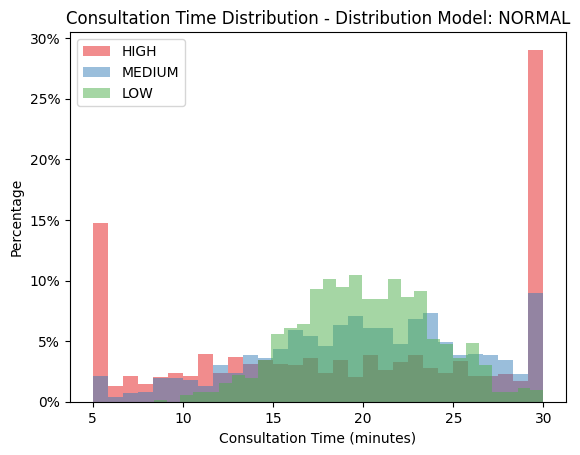

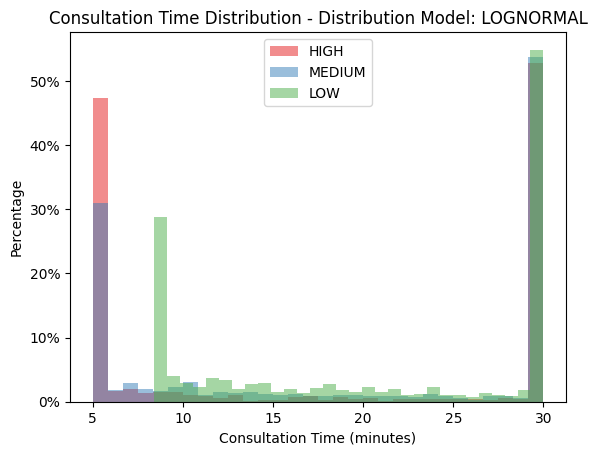



Results for Volatility: HIGH, Distribution Model: NORMAL
Min Consult Time: 5.00
Max Wait Time: 30.00
Mean Wait Time: 19.13
Lower Quartile Wait Time: 11.47
Median Wait Time: 19.64
Upper Quartile Wait Time: 28.56
IQR Wait Time: 17.09


Results for Volatility: HIGH, Distribution Model: LOGNORMAL
Min Consult Time: 5.00
Max Wait Time: 30.00
Mean Wait Time: 17.52
Lower Quartile Wait Time: 5.00
Median Wait Time: 16.27
Upper Quartile Wait Time: 30.00
IQR Wait Time: 25.00


Results for Volatility: MEDIUM, Distribution Model: NORMAL
Min Consult Time: 5.00
Max Wait Time: 30.00
Mean Wait Time: 20.08
Lower Quartile Wait Time: 16.17
Median Wait Time: 20.30
Upper Quartile Wait Time: 24.24
IQR Wait Time: 8.07


Results for Volatility: MEDIUM, Distribution Model: LOGNORMAL
Min Consult Time: 5.00
Max Wait Time: 30.00
Mean Wait Time: 19.10
Lower Quartile Wait Time: 5.38
Median Wait Time: 22.34
Upper Quartile Wait Time: 30.00
IQR Wait Time: 24.62


Results for Volatility: LOW, Distribution Model: NORMAL

In [10]:
results = test_consultation_time_distribution()
print_consult_times_test(results, True)

Let's have a closer look at `MEDIUM` vs `LOW` volatility with the `NORMAL` distribution

Finished Tests



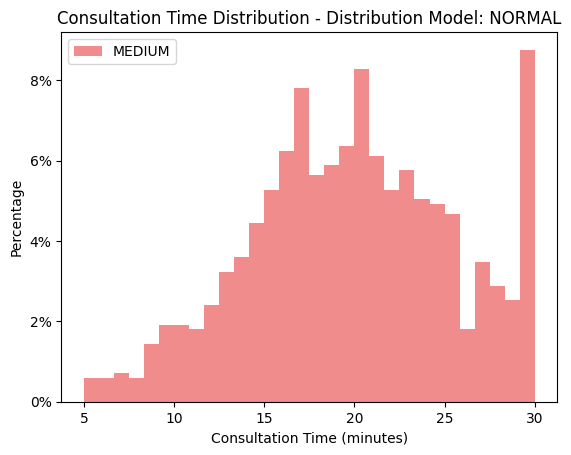



Finished Tests



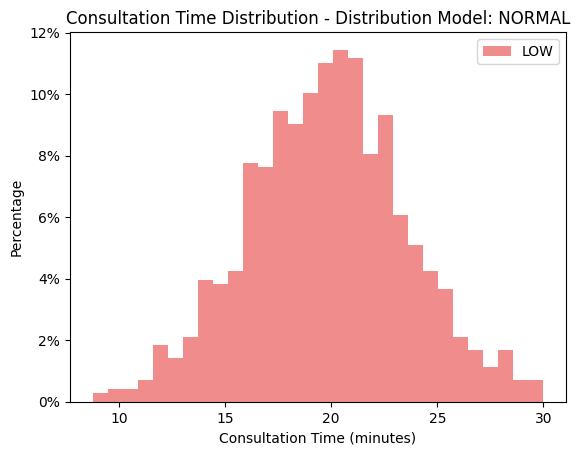

In [11]:
result = test_consultation_time_distribution(volatilty_setting=Volatility['MEDIUM'], model_setting=DistributionModel['NORMAL'])
print_consult_times_test(result, True, True, True)
result = test_consultation_time_distribution(volatilty_setting=Volatility['LOW'], model_setting=DistributionModel['NORMAL'])
print_consult_times_test(result, True, True, True)

`MEDIUM` volatility with a `NORMAL` model seems to give a good distribution for patient consultation times. If we were unable to find a good distribution then we could look at changing how this method is implemented.
> ### Possible Extension
> We could extend the Patient class to take a random condition. We could give each condition a fixed probability of occuring based on A&E data. We could also give each condition its own values for min, max, and expected consultation times.
> This does mean changing our model a bit, but the changes are not too drastic due to how the simulation has been built. This type of change could be very useful if the simulation is further extended to model more specific patient outcomes, such as time waiting for a test and full consultation time.

## Using Simulation

If we are happy that the simulation seems to be giving us sensible results then we can use it to probe for the right number of ANPs at a given demand level

In [12]:
print("Assessment model:")
for level in DemandLevel:
  print(f"For {level.value} patients per hour")
  for num_ANPs in range(1, 20):
    sim = Simulation(level, num_ANPs)
    _, avg_breaches, *_, avg_arrivals = sim.simulate()
    breach_percent = 100 * (avg_breaches / avg_arrivals)
    if breach_percent <= 10:
      print(f"ANPs needed for average breach rate <= 10%: {num_ANPs}")
      break
print("\nStreaming model:")
for level in DemandLevel:
  print(f"For {level.value} patients per hour")
  for num_ANPs in range(1, 20):
    # Change the break limits so there is no automatic break and any break requires at least 6 patients
    sim = Simulation(level, num_ANPs, max_time=4.5 ,min_time=1.5, expected_time=2.5, min_break_no=6, max_break_no=100)
    _, avg_breaches, *_, avg_arrivals = sim.simulate()
    breach_percent = 100 * (avg_breaches / avg_arrivals)
    if breach_percent <= 10:
      print(f"ANPs needed for average breach rate <= 10%: {num_ANPs}")
      break

Assessment model:
For 5 patients per hour
ANPs needed for average breach rate <= 10%: 3
For 10 patients per hour
ANPs needed for average breach rate <= 10%: 4
For 15 patients per hour
ANPs needed for average breach rate <= 10%: 6
For 20 patients per hour
ANPs needed for average breach rate <= 10%: 7
For 25 patients per hour
ANPs needed for average breach rate <= 10%: 9

Streaming model:
For 5 patients per hour
ANPs needed for average breach rate <= 10%: 1
For 10 patients per hour
ANPs needed for average breach rate <= 10%: 1
For 15 patients per hour
ANPs needed for average breach rate <= 10%: 2
For 20 patients per hour
ANPs needed for average breach rate <= 10%: 2
For 25 patients per hour
ANPs needed for average breach rate <= 10%: 2


The additional logic the ANP runs through when calling in a patient will make a much bigger difference when modelling the streaming system. In many ways this highlights the power of a simulation.

Firstly you can move around the basic values in the ANP implementation to try and get this closer to reality. For example if data exists on these timings then you can make it more precise, if data does not exist then you may want to measure some of these things for several consultations as a one-off. You don't need a lot of data, you just need a rule of thumb understanding.

Once the simulation is matching up with reality you can then start wondering what difference an improvement in one of these would make. E.g. adding more screens to tell patients to go into a room could speed up patient journey time by 10 seconds. What difference will this make? The simulation will tell you if it is meaningful.

## Further Testing

Let's explore the `VERY_HIGH` level of demand further, varying our breach target and the number of ANPs required to handle it and see how it performs. For example you may have noticed that the average number of arrivals always seems too low for the demand. That is because we are not counting waiting patients that still haven't breached. We can see if this is an issue by increasing our simulations duration.

In [13]:
level = DemandLevel["VERY_HIGH"].value
print(f"Looking at demand levels of {level} patients per hour:\n")

breach = 0
sim_runs = 1000

for breach in [15, 20, 30]:
  for ANPs in range(7, 10):
    print(f"Statistics for {ANPs} ANPs with a {breach} minute breach target:")
    run_and_print_simulation(level, ANPs, wait_control = breach,
                             duration=120, num_simulations= sim_runs)

Looking at demand levels of 25 patients per hour:

Statistics for 7 ANPs with a 15 minute breach target:
Simulation Results for 25 Patients per Hour with 7 ANPs:
  - Average Wait Time: 19.70 mins
  - Average Breach Rate: 71.3%
  - Average Patients Waiting: 8.26
  - Average ANP Idle Time: 4.55 mins per hour
  - Average Time in System: 34.35 mins
  - Average Consultation Time: 19.90 mins
  - Average Patients Not Seen: 8.06
  - Average No. Arrivals: 43.82
  - Number of runs: 1,000
  - Sim Run Duration: 120 minutes
  - Full Run Duration: 150 minutes
--------------------------------------------------

Statistics for 8 ANPs with a 15 minute breach target:
Simulation Results for 25 Patients per Hour with 8 ANPs:
  - Average Wait Time: 12.51 mins
  - Average Breach Rate: 39.2%
  - Average Patients Waiting: 5.08
  - Average ANP Idle Time: 10.55 mins per hour
  - Average Time in System: 29.36 mins
  - Average Consultation Time: 19.91 mins
  - Average Patients Not Seen: 2.52
  - Average No. Arriv

Even 7 ANPs is not too bad, the average wait time is less than 5 minutes over our breach. Considering that 25 patients per hour is an extremely high demand level it may be worth moving on from here to model shift patterns if the `VERY_HIGH` rate of demand is only a brief period of the day.

What will happen when we get to the peak 25 per day period is our 7 ANP work-force will fall behind. It will then catch back up as this drops. How this works is not easily predictable, but we can get a good estimate through simulation.

This then gets us closer to real world scenarios where we need to think about things like minimum numbers of staff. We could revise our simulation to calculate an optimum set of 8 hour shift patterns throughout the day.

## How does the simuluation work?

The simulation can be understood by examining the `Simulation` class. First of all each element is set up as an object. The simulation class essentially acts as something akin to a games master, using the different objects of the program.

After reading in the settings for the simulation we begin by creating our ANPs and initialising variables we will use to track progress in the simulation.

We then run a method called `generate_patient_arrivals()`

`generate_patient_arrivals` will return a list of arrival times for every patient in that run of the simulation. Because each arrival is an independent event we can use the `randint` function from the `random` library to spread the arrivals across the duration of the simulation.

Remember that the simulation runs a certain number of minutes before recording statistics. By default this is 30 (it is initialised through the `self.PRE_RUN_MINUTES` constant).

We generate patients based on the demand level and duration of the simulation. A 90 minute simulation with 10 patients an hour will generate 15 patients. The arrival of each patient is random, so we may not get 10 patients in the final 60 minutes we are measuring, we could have a few more or a few less, but there will always be 15 patients entered into the simulation run.

Once we have a list of random arrival times we sort the list so it is in order and are then ready to start the simulation.

We begin by looping through each tick. A tick is an increment in time. Currently the simulation is set so it ticks forward every 6 seconds.

Every tick we check our `patient_arrivals` list. If a patient or patients arrive in that tick then we remove that time from the list and create the patient(s).

When patients are created they generate a consultation length which is random and distributed based on the model settings. They are then moved into the waiting room.

We then check through each ANP. We ask each ANP to update their status and then check if the ANP is free. If the ANP is free then we check if the waiting room has any waiting patients. If there is a patient waiting then we call the ANP's `start_consultation` method, which moves the patient out of the waiting area and into a list of seen patients.

The ANP has its own internal rules that will add some small but random delays to the patient journey and when the next patient is called in.

Once our build up has run (by default this is set to 30 minutes), we start collecting some statistics.

Carrying on the process above for each minute, we now additionally start collecting ANP idle time. If an ANP is idle in a given minute then the ANP will add 1 to a list. Once our simulation has finished we will sum up the list and divide by the number of ANPs to get an averaged idle time for the run.

We also count the number of patients waiting to be seen. This will be averaged at the end of the simulation.

Finally we check if any patient waiting times have breached our limit. Patients carry a flag with them that is raised whenever we count them as having breached. This ensures we do not count the same patient twice when checking our breach standard.

The loop continues until the simulation run has finished. We then collect our remaining statistics. Each patient holds information on how long they waited and how long they were seen for. This is collected and averaged for the run.

The final part of the puzzle is running the simulation over and over. This is handled by the `simulate()` method. This method runs each simulation and collects the results into a list called `accumulated_stats`, which is then averaged, giving our final results.

*If you want to interact with this notebook but would rather not change any of the code then run the cell below. This will create some widgets which make interacting with the simulation a bit easier.*

In [14]:
# Bring in interact
from ipywidgets import interact, interactive, fixed, Output
import ipywidgets as widgets

# Set up widget settings, button and output
style = {'description_width': 'initial'}
widget_layout = widgets.Layout(width='400px')
button = widgets.Button(description="Run Simulation")
output = Output()
with output:
  print("\nClick the Run Simulation button to run the simulation\n")
# Create widgets
d_level = widgets.Dropdown(description="Demand Level:", layout=widget_layout, style=style, value="MEDIUM", options=['VERY_LOW','LOW','MEDIUM','HIGH','VERY_HIGH'])
n_ANPs = widgets.IntSlider(description="Number of ANPs:", layout=widget_layout, style=style, min=1, max=20, step=1, value=5)
sim_mins = widgets.IntSlider(description="Duration of each run (mins):", layout=widget_layout, style=style, min=30, max=180, step=10, value=DEFAULT_MODEL_DURATION)
breach_lim = widgets.IntSlider(description="Wait Target:",layout=widget_layout, style=style, min=0, max=60, step=1, value=DEFAULT_CONTROL_LIMIT)
mx_time = widgets.FloatSlider(description="Max Assessment Time (mins):", layout=widget_layout, style=style, min=1, max=60, step=1, value=float(DEFAULT_MAX_CONSULT_TIME))
mn_time = widgets.FloatSlider(description="Min Assessment Time (mins):", layout=widget_layout, style=style, min=1, max=60, step=1, value=float(DEFAULT_EXPECTED_CONSULT_TIME))
ex_time = widgets.FloatSlider(description="Average Assessment Time (mins):", layout=widget_layout, style=style, min=1, max=60, step=1, value=float(DEFAULT_MIN_CONSULT_TIME))
num_runs = widgets.IntSlider(description="Number of times to repeat simulation:", layout=widget_layout, style=style, min=1, max=10000, step=5, value=DEFAULT_SIM_RUNS)

# Set up button
def on_button_clicked(b):
  with output:
    output.clear_output()
    print("\nClick the Run Simulation button to re-run the simulation\n")
    run_and_print_simulation(demand_level=d_level.value, num_ANPs=n_ANPs.value, duration=sim_mins.value, wait_control=breach_lim.value, max_time=mx_time.value,
          expected_time=ex_time.value, min_time=mn_time.value, num_simulations=num_runs.value, model_volatility=DEFAULT_VOLATILITY, consult_dist=DEFAULT_MODELLING)
# Attach to button
button.on_click(on_button_clicked)

# Set up ui
tab1 = widgets.VBox(children=[widgets.HBox(children=[n_ANPs, breach_lim]), ex_time, mx_time, mn_time])
tab2 = widgets.VBox(children=[d_level, widgets.HBox(children=[sim_mins, num_runs])])
tab = widgets.Tab(children=[tab1, tab2])
tab.set_title(0, "Model Settings")
tab.set_title(1, "Simulation Settings")
ui = widgets.VBox(children=[tab, button])

# Run
print("Use the widgets below to change the settings of the model and simulation:\n")
display(ui)
display(output)

Use the widgets below to change the settings of the model and simulation:



Output()

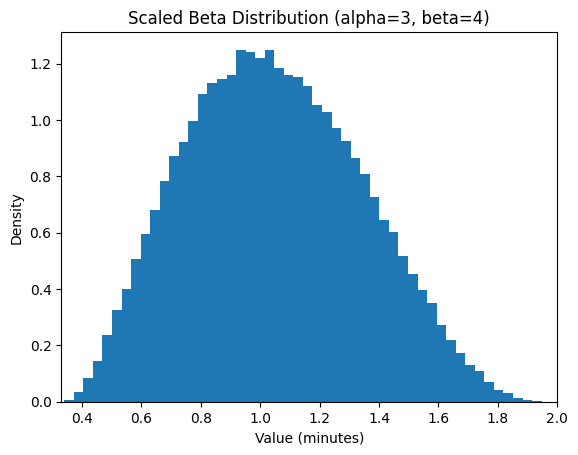

In [15]:
# If you are interested in how the beta-distribution (used to model some of our delay factors in the ANP class)
# then the code below can be run to view and play around with this

# Parameters for the beta distribution
alpha, beta = 3, 4 # Used by ANP admin time

# Range limits
min_delay, max_delay = 0.33, 2.0 # Used by ANP admin time

# Generate a large number of values
values = [min_delay + (max_delay - min_delay) * random.betavariate(alpha, beta) for _ in range(90000)]

# Plot the distribution of these values
plt.hist(values, bins=50, density=True)
plt.title(f'Scaled Beta Distribution (alpha={alpha}, beta={beta})')
plt.xlabel('Value (minutes)')
plt.ylabel('Density')
plt.xlim(min_delay, max_delay)  # Set the x-axis limits to match our range
plt.show()